In [360]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

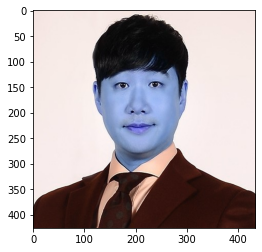

In [361]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
#img_bgr = cv2.resize(img_bgr, (435, 426))    # 원본사이즈로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv를 통해 이미지를 읽어옴.그런데 matplot은 rgb의 순서대로 이미지를 다루는 반면, opencv는 bgr순으로 이미지를 다루기 때문에 색이 이상하게 나온다. 따라서 cv2.cvColor로 bgr값에서 rgb값으로 컬러를 뒤집어주어야한다. 



https://076923.github.io/posts/Python-opencv-10/

색상 공간 변환 함수(cv2.cvtcolor)로 이미지의 색상 공간을 변경할 수 있습니다.

dst = cv2.cvtcolor(src, code, dstCn)는 입력 이미지(src), 색상 변환 코드(code), 출력 채널(dstCn)으로 출력 이미지(dst)을 생성합니다.

색상 변환 코드는 원본 이미지 색상 공간2결과 이미지 색상 공간을 의미합니다.

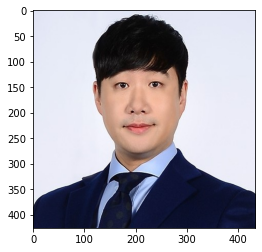

In [362]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [363]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print(dlib_rects)

rectangles[[(132, 116) (287, 270)]]


rectangles[[(132, 116) (287, 270)]]


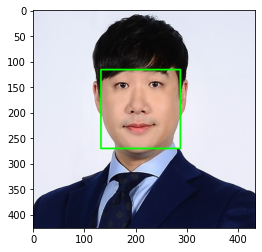

In [364]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

dlib객체를 통해 얼굴을 검출할 수 있다. dlib 또한 rgb값으로 이미지를 처리하기 때문에 rgb로 바꾸어준 후에 이미지를 표시했다. 
dlib객체는 이미지를 흑백으로 바꾸어 색상값이 어두어지는 값으로 화살표를 그어 경계를 긋고 얼굴을 찾아낸다. 

In [365]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


In [366]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


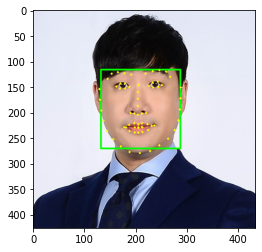

In [367]:
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴의 경계 사각형 내에서 눈코입의 좌표를 찾아내기 위해 landmark모델을 받아온다. 

points = landmark_predictor(img_rgb, dlib_rect) 
-> land_predictor 함수에 이미지와 사각형 좌표를 넣어주면 경계값들의 68개의 좌표를 반환한다. 

이후 68개의 좌표가 어디인지 확인하기 위해 cv2.circle(img_show, point, 2, (0, 255, 255), -1) yellow로 원을 찍는다.

이후 이미지를 표시해보면 해당 이미지의 경계값이 어디인지 확인할 수 있다. 

In [368]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(204, 187)
(x,y) : (204,109)
(w,h) : (156,156)


In [369]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
sticker = cv2.imread(sticker_path)
sticker = cv2.resize(sticker, (w,h))
print (sticker.shape)

(156, 156, 3)


In [370]:
refined_x = x - w // 2  # left
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (126,31)


In [371]:
sticker_area = img_bgr[y:y+sticker.shape[0], refined_x:refined_x+sticker.shape[1]]
img_bgr[y:y+sticker.shape[0], refined_x:refined_x+sticker.shape[1]] = \
    np.where(sticker==255, sticker_area, sticker).astype(np.uint8)

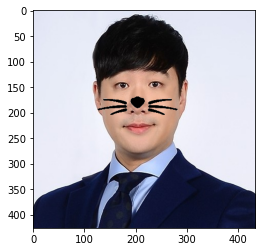

In [372]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

1. 코 중앙의 x좌표와 y좌표로 넣으면 된다고 생각했다. 코 중앙은 68개의 좌표값 중 30번째에 있기 때문에 30번째 x,y를 불러왔다. 
2. 수염의 사이즈는 수염 전체 사진 사이즈가 dlib_rect와 같으면 될 것이라 생각했다. 따라서 resize를 dlib_rect의 넓이로 했다. 
3. 위치시킬 때에는 x,y 좌표의 각각의 좌표에 수염의 shape을 더해주었다. 그리고 흰색배경은 나오지 않게하기위해 np.where를 사용했다.  

#회고
처음엔 이미지 자체에서 얼굴의 경계선을 찾는 것조차 되지않아 많이 애를 먹었다. 나중에 알고보니 이미지의 사이즈를 변환하는 과정에서 
원본 이미지의 비율을 맞춰주지 않아 그렇다는 것을 깨달았다. 그래서 원본 비율을 맞춰주고 보니 경계선을 찾을 수 있었다.

이후 수염을 조정하는 과정에선 자꾸 수염이 엇나가서 힘들었다. 이후 단순하게 생각해보니 수염 사진의 크기는 흰 배경화면을 포함한 크기니까 
얼굴 크기에 수염 사이즈를 맞추면 된다고 생각했고 위치는 코 중앙에 넣으면 된다고 생각하니 생각보다 쉽게 되었다. 

하지만 이는 단순히 사각형 형태에 수염을 맞추기만 한 것이라서, 옆쪽을 바라보는 등 수염의 각도조정을 고려하지못한 것이다. 이에 대해선 차후에 고민해봐야되겠다. 